# Build anomaly 2060-2099 (2160-2199) wrt 1979-2018 onto JRA grid

## Load modules

In [4]:
import xarray as xr
import numpy  as np
import pandas as pd
from datetime import datetime
import copy as copy

## Core functions

### compute 3h anomaly (with and without leap year)

In [5]:
def compute_1m_to_3h_ano(ds_month_ano):
    """
    Purpose: compute 3h anomaly based on a monthly file
    
    Args:
        ds_month_ano : monthly anomaly [xarray dataset]
        
    Return: 
        ds_3h_ano : 3hourly anomaly [xarray dataset]
    """
    
    # Concat last 3 months at the beginning and first 3 month at the end
    # It is needed for a coorect interpolation as the end (31st december should match the 1st January minus 1 day)
    # 3 month as depending of the stencil of the interpolation scheme it could be needed
    m0=ds_month_ano.isel(month=[9,10,11])
    m0['month']=m0['month']-pd.Timedelta(days=365)
    m13=ds_month_ano.isel(month=[0,1,2])
    m13['month']=m13['month']+pd.Timedelta(days=365)
    ds_3h_ano=xr.concat([m0,ds_month_ano,m13],dim='month')

    # resampling with quadratic interpolation
    ds_3h_ano=ds_3h_ano.resample(month="3H").interpolate("quadratic")

    # select data only between 1st January to 31st december
    ds_3h_ano=ds_3h_ano.sel(month=slice('{:d}-01-01'.format(idateout), '{:d}-12-31'.format(idateout)))

    return ds_3h_ano

### Add overlap to dataset

In [29]:
def add_EW_overlap(ds):
    """
    Purpose: add 3 overlap cell on East and West boundary (useful before interpolation)
    
    Args:
        ds : input dataset [xarray dataset]
        
    Return: 
        ds : output dataset with the 3 most Eastern cells added at the West bnd 
             and the 3 most Western cells added at the East bnd [xarray dataset]
    """
    
    # Concat last 3 months at the beginning and first 3 month at the end
    # It is needed for a coorect interpolation as the end (31st december should match the 1st January minus 1 day)
    # 3 month as depending of the stencil of the interpolation scheme it could be needed
    lon0=ds.isel(lon=slice(-3,None,1))
    lon0['lon'] = lon0['lon']-360.
    
    lon360=ds.isel(lon=slice(0,3,1))
    lon360['lon'] = lon360['lon']+360.
    
    return xr.concat([lon0,ds_in,lon360],dim='lon')

### Define new attributes

In [45]:
def modify_attributes_anomaly(cvar,dattrs,ds):
    """
    Purpose: modify variable reference attributes
    
    Args:
        dattrs : old attributes [dict]
        cvar   : variable name used to extract min and max [ string ]
        ds     : dataset from where min and max are extracted [ xarray dataset ]
        
    Return: 
        dattrs : new attributes [dict]
    """
    
    # get rid of non sense attributes
    if 'time' in list(dattrs.keys()):
        del dattrs["time"]
    if 'date' in list(dattrs.keys()):
        del dattrs["date"]
        
    # modify existing attributes
    dattrs["standard_name"] = dattrs["standard_name"]+'_anomaly'
    dattrs["description"]   = dattrs["description"]+' anomaly'
    dattrs["long_name"]     = dattrs["long_name"]+' anomaly'
    
    # compute new valid range
    dattrs["valid_min"] = ds[cvar].min().values
    dattrs["valid_max"] = ds[cvar].max().values
    
    return dattrs

## Sanity check function

### Display global mean anomaly

In [18]:
def print_annual_global_mean_ano(ds_ano,cvar):
    """
    Purpose: print annual global mean
    
    Args:
        ds_ano : dataset used to extract annual global mean [xarray dataset]
        cvar   : variable name used to extract annual global mean [ string ]
        
    Warning : grid is assumed to be regular and to scale with latitude
    """
    
    # compute annual anomaly
    zds=ds_ano[cvar].mean(dim='month')
    
    # compute weights
    weights = np.cos(np.deg2rad(zds.lat,dtype=np.float64))
    
    # compute weighted xarray
    weights.name = "weights"
    zds = zds.weighted(weights)
    
    # display anomaly
    print('        annual mean anomaly is : ',zds.mean(("lon", "lat")).values)

## Parameters

In [ ]:
# data dir path
cdirref='REF_IPSL/'
cdirtrg='SSP85/'

# JRA grid
cfout_grid='./JRA55_grid.nc'

# list of file variables to process and the corresponding infile variables
fvarlst=['huss','pr','prsn','ps','rlds','rsds','tas','uas','vas']
cvarlst=['huss','pr','prsn','ps','rlds','rsds','tas','uas','vas']

# reference period
yrefs=1975; yrefe=2014

# trg period
ytrgs=2260; ytrge=2299

cfext = '{:d}{:d}-{:d}{:d}'.format(ytrgs,ytrge,yrefs,yrefe)

idateout = 1951 # use a non leap year (0001 is out of bound for date_range pandas function )

# slice definition
slc_ref=slice('{:d}-01-01'.format(yrefs), '{:d}-01-01'.format(yrefe))
slc_trg=slice('{:d}-01-01'.format(ytrgs), '{:d}-01-01'.format(ytrge))

## Process data

In [10]:
print('Compute 3h anomaly between period {:d}-{:d} and {:d}-{:d} for data in {}'.format(ytrge,ytrgs,yrefe,yrefs,cdir))
print()

Compute 3h anomaly between period 2299-2260 and 2014-1975 for data in REF_IPSL/



### Compute 3 hourly anomaly from monthly data

For each variable, the steps are :
 - open data
 - compute climato
 - compute anomaly
 - sample to 3h (quadratic interpolation)
 - write data

In [30]:
# for each variable
for ivar,fvar in enumerate(fvarlst):
    cvar=cvarlst[ivar]
    cdvar='d'+cvar

    print('Processing of {} ({}) in progress ...'.format(fvar,cvar))
    
    # load data reference
    print('    load reference data ...')
    cfrefin1='{}/{}_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_{}0116-{}1216_v20180803.nc'.format(cdirref,fvar,yrefs,yrefe)
    print('        file : {}'.format(cfrefin1))
    ds_ref = xr.open_dataset(cfrefin1)
    
    # load data trg
    print('    load period data ...')
    cftrgin1='{}/{}_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_{}0116-{}1216_v20190903.nc'.format(cdirtrg,fvar,ytrgs,ytrge,)
    print('        file : {}'.format(cftrgin1))
    ds_trg = xr.open_dataset(cftrgin1).squeeze()
    
    # drop useless variables
    #if 'ht' in list(ds_ref.coords.keys()):
    #    ds_ref=ds_ref.drop('ht');
    #    ds_trg=ds_trg.drop('ht')
        
    # compute climato
    print('    build monthly climato ...')
    ds_ref_clim=ds_ref.sel(time=slc_ref).groupby('time.month').mean(dim='time')
    ds_trg_clim=ds_trg.sel(time=slc_trg).groupby('time.month').mean(dim='time')

    # compute anomaly
    print('    compute anomaly ...')
    ds_trg_ano = ds_trg_clim - ds_ref_clim

    # print global annual mean anomaly
    print_annual_global_mean_ano(ds_ref_clim,cvar)
    print_annual_global_mean_ano(ds_trg_clim,cvar)
    print_annual_global_mean_ano(ds_trg_ano,cvar)
    
    # update month dimension (use idateout as dummy date 0001 was not possible (out of bound))
    ds_trg_ano['month']=pd.date_range("{:d}/01/15".format(idateout),periods=12,freq=pd.DateOffset(months=1))
    
    # compute 3h anomaly (with and without leap year)
    ds_3h_ano=compute_1m_to_3h_ano(ds_trg_ano)
    
    # rename time dim
    ds_3h_ano=ds_3h_ano.rename({'month': 'time'})
    
    # rename variable
    ds_3h_ano=ds_3h_ano.rename({cvar:cdvar})
    
    # add variable attributes
    ds_3h_ano['d'+cvar].attrs = modify_attributes_anomaly(cdvar,ds_ref[cvar].attrs,ds_3h_ano)
    
    # add global attributes
    print('    write global att ...')
    ds_3h_ano.attrs =  { 'Description' : 'The above anomaly file is the differences between a specific period and a reference period',
                         'Specific Period' : '{:d} - {:d}'.format(ytrge, ytrgs),
                         'Reference period' : '{:d} - {:d}'.format(yrefe, yrefs),
                         'Model' : 'IPSL-CM6A-LR',
                         'Scenario'   : 'ssp585 - historical',
                         'Contact':'P. Mathiot (IGE)',
                         'Creation date':'{}'.format(datetime.now()),
                        }
    
    # write data
    print('    write data ...')
    cfout="IPSL-CM6A-LR_ssp585-historical_{}_3h_ano_{}.nc".format(fvar,cfext)
    print('        file : {} ...'.format(cfout))
    ds_3h_ano.to_netcdf('./'+cfout,unlimited_dims='time',encoding={'time' : {'dtype': 'float64'}})
    
    print('')
    print('')

Processing of huss (huss) in progress ...
    load reference data ...
        file : REF_IPSL//huss_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19750116-20141216_v20180803.nc
    load period data ...
        file : SSP85//huss_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_22600116-22991216_v20190903.nc
    build monthly climato ...


/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


    compute anomaly ...
        annual mean anomaly is :  0.00977362459324868
        annual mean anomaly is :  0.019745440361851625
        annual mean anomaly is :  0.009971815755212705
    write global att ...
    write data ...
        file : IPSL-CM6A-LR_ssp585-historical_huss_3h_ano_22602299-19752014.nc ...


Processing of pr (pr) in progress ...
    load reference data ...
        file : REF_IPSL//pr_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19750116-20141216_v20180803.nc
    load period data ...
        file : SSP85//pr_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_22600116-22991216_v20190903.nc
    build monthly climato ...


/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


    compute anomaly ...
        annual mean anomaly is :  3.485970897868827e-05
        annual mean anomaly is :  4.197715047805889e-05
        annual mean anomaly is :  7.117441495668283e-06
    write global att ...
    write data ...
        file : IPSL-CM6A-LR_ssp585-historical_pr_3h_ano_22602299-19752014.nc ...


Processing of prsn (prsn) in progress ...
    load reference data ...
        file : REF_IPSL//prsn_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19750116-20141216_v20180803.nc
    load period data ...
        file : SSP85//prsn_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_22600116-22991216_v20190903.nc
    build monthly climato ...


/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


    compute anomaly ...
        annual mean anomaly is :  2.7003322767888803e-06
        annual mean anomaly is :  7.959539558367227e-07
        annual mean anomaly is :  -1.9043783259458603e-06
    write global att ...
    write data ...
        file : IPSL-CM6A-LR_ssp585-historical_prsn_3h_ano_22602299-19752014.nc ...


Processing of ps (ps) in progress ...
    load reference data ...
        file : REF_IPSL//ps_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19750116-20141216_v20180803.nc
    load period data ...
        file : SSP85//ps_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_22600116-22991216_v20190903.nc
    build monthly climato ...


/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


    compute anomaly ...
        annual mean anomaly is :  98507.57542846196
        annual mean anomaly is :  98507.57262427911
        annual mean anomaly is :  -0.002659321102776582
    write global att ...
    write data ...
        file : IPSL-CM6A-LR_ssp585-historical_ps_3h_ano_22602299-19752014.nc ...


Processing of rlds (rlds) in progress ...
    load reference data ...
        file : REF_IPSL//rlds_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19750116-20141216_v20180803.nc
    load period data ...
        file : SSP85//rlds_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_22600116-22991216_v20190903.nc
    build monthly climato ...


/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


    compute anomaly ...
        annual mean anomaly is :  342.1887148434055
        annual mean anomaly is :  432.31849195051143
        annual mean anomaly is :  90.12977703900117
    write global att ...
    write data ...
        file : IPSL-CM6A-LR_ssp585-historical_rlds_3h_ano_22602299-19752014.nc ...


Processing of rsds (rsds) in progress ...
    load reference data ...
        file : REF_IPSL//rsds_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19750116-20141216_v20180803.nc
    load period data ...
        file : SSP85//rsds_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_22600116-22991216_v20190903.nc
    build monthly climato ...


/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


    compute anomaly ...
        annual mean anomaly is :  188.9539260089094
        annual mean anomaly is :  182.62966088863232
        annual mean anomaly is :  -6.324265205077023
    write global att ...
    write data ...
        file : IPSL-CM6A-LR_ssp585-historical_rsds_3h_ano_22602299-19752014.nc ...


Processing of tas (tas) in progress ...
    load reference data ...
        file : REF_IPSL//tas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19750116-20141216_v20180803.nc
    load period data ...
        file : SSP85//tas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_22600116-22991216_v20190903.nc
    build monthly climato ...


/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


    compute anomaly ...
        annual mean anomaly is :  286.8090899022573
        annual mean anomaly is :  299.83479379562783
        annual mean anomaly is :  13.025703541933082
    write global att ...
    write data ...
        file : IPSL-CM6A-LR_ssp585-historical_tas_3h_ano_22602299-19752014.nc ...


Processing of uas (uas) in progress ...
    load reference data ...
        file : REF_IPSL//uas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19750116-20141216_v20180803.nc
    load period data ...
        file : SSP85//uas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_22600116-22991216_v20190903.nc
    build monthly climato ...


/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


    compute anomaly ...
        annual mean anomaly is :  -0.40362507839777856
        annual mean anomaly is :  -0.4790724829652258
        annual mean anomaly is :  -0.07544740479960352
    write global att ...
    write data ...
        file : IPSL-CM6A-LR_ssp585-historical_uas_3h_ano_22602299-19752014.nc ...


Processing of vas (vas) in progress ...
    load reference data ...
        file : REF_IPSL//vas_Amon_IPSL-CM6A-LR_historical_r1i1p1f1_gr_19750116-20141216_v20180803.nc
    load period data ...
        file : SSP85//vas_Amon_IPSL-CM6A-LR_ssp585_r1i1p1f1_gr_22600116-22991216_v20190903.nc
    build monthly climato ...


/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/xarray/coding/times.py:527: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/numpy/core/_asarray.py:102: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


    compute anomaly ...
        annual mean anomaly is :  0.18314202321256468
        annual mean anomaly is :  0.18035393113943668
        annual mean anomaly is :  -0.002788092221369884
    write global att ...
    write data ...
        file : IPSL-CM6A-LR_ssp585-historical_vas_3h_ano_22602299-19752014.nc ...




## Interpolate onto JRA grid

### Load JRA grid

In [31]:
cfJRA = cfout_grid
ds_JRA = xr.open_dataset(cfJRA)
lat_JRA=ds_JRA['lat']
lon_JRA=ds_JRA['lon']

### Interpolate HadCM3 data to JRA grid

In [75]:
for ivar,fvar in enumerate(fvarlst):
    cvar=cvarlst[ivar]
    cdvar='d'+cvar
    
    # load data in
    print('    load IPSL data ...')
    cfin='./IPSL-CM6A-LR_ssp585-historical_{}_3h_ano_{}.nc'.format(fvar,cfext)
    print('        file : {}'.format(cfin))
    ds_in = xr.open_dataset('./'+cfin)
    
    print('    extend input data E and W by 3 data points ...')
    ds_in = add_EW_overlap(ds_in)
    
    print('    interpolate data onto JRA grid ...')
    print('        method = cubic')
    ds_out = ds_in.interp(lat=lat_JRA, lon=lon_JRA, method='cubic')
    
    print('    clean output data set ...')
    print('        update valid range attributes ...')
    ds_out[cdvar].attrs['valid_min']=ds_out[cdvar].min().values
    ds_out[cdvar].attrs['valid_max']=ds_out[cdvar].max().values
    
    # set coordinates
    ds_out[cdvar].assign_coords({"lon": ds_out['lon'], "lat": ds_out['lat'], "time": ds_out['time']})
    
    print('        update global attributes ...')
    ds_out.attrs['Description']=ds_out.attrs['Description']+' interpolated onto JRA55 grid with a cubic method'
    ds_out.attrs['Grid']='JRA55 grid'
    ds_out.attrs['Creation date'] = '{}'.format(datetime.now())
    
    print('    write data interpolated onto JRA grid ...')
    cfout='IPSL-CM6A-LR_ssp585-historical_{}_3h_ano_{}_on_JRA_grid.nc'.format(fvar,cfext)
    print('        file : ',cfout)
    ds_out.to_netcdf('./'+cfout)
    
    print()
    print()

    load IPSL data ...
        file : ./IPSL-CM6A-LR_ssp585-historical_huss_3h_ano_22602299-19752014.nc
    extend input data E and W by 3 data points ...
    interpolate data onto JRA grid ...
        method = cubic
    clean output data set ...
        update valid range attributes ...
        update global attributes ...
    write data interpolated onto JRA grid ...
        file :  IPSL-CM6A-LR_ssp585-historical_huss_3h_ano_22602299-19752014_on_JRA_grid.nc


    load IPSL data ...
        file : ./IPSL-CM6A-LR_ssp585-historical_pr_3h_ano_22602299-19752014.nc
    extend input data E and W by 3 data points ...
    interpolate data onto JRA grid ...
        method = cubic
    clean output data set ...
        update valid range attributes ...
        update global attributes ...
    write data interpolated onto JRA grid ...
        file :  IPSL-CM6A-LR_ssp585-historical_pr_3h_ano_22602299-19752014_on_JRA_grid.nc


    load IPSL data ...
        file : ./IPSL-CM6A-LR_ssp585-historical_p

In [62]:
# set coordinates
ds_out['dhuss'].assign_coords({"lon": ds_out['lon'], "lat": ds_out['lat'], "time": ds_out['time']})
    
print(ds_out)  
ds_out.to_netcdf('./toto.nc')

<xarray.Dataset>
Dimensions:  (time: 2920, lat: 320, lon: 640)
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1951-01-01 ... 1951-12-31T21:00:00
  * lat      (lat) float64 -89.57 -89.01 -88.45 -87.89 ... 88.45 89.01 89.57
  * lon      (lon) float64 0.0 0.5625 1.125 1.688 ... 357.8 358.3 358.9 359.4
Data variables:
    dhuss    (time, lat, lon) float64 0.001814 0.001813 ... 0.005851 0.00585
Attributes:
    Description:       The above anomaly file is the differences between a sp...
    Specific Period:   2299 - 2260
    Reference period:  2014 - 1975
    Model:             IPSL-CM6A-LR
    Scenario:          ssp585 - historical
    Contact:           P. Mathiot (IGE)
    Creation date:     2022-01-31 12:06:53.308409
    Grid:              JRA55 grid


In [76]:
    fvar='huss'
    print('    load anomaly data ...')
    cfile='IPSL-CM6A-LR_ssp585-historical_{}_3h_ano_{}_on_JRA_grid.nc'.format(fvar,cfext)
    print('        file : {}'.format(cfile))
    ds_month = xr.open_dataset(cfile).sel(lat=slice(-90,-60))

    load anomaly data ...
        file : IPSL-CM6A-LR_ssp585-historical_huss_3h_ano_22602299-19752014_on_JRA_grid.nc


In [79]:
ds_month['dhuss'].values


array([[[0.00181364, 0.00181312, 0.0018124 , ..., 0.00181404,
         0.00181393, 0.00181385],
        [0.00187229, 0.00187103, 0.00186938, ..., 0.00187339,
         0.00187311, 0.00187284],
        [0.00190959, 0.00190765, 0.00190515, ..., 0.0019115 ,
         0.00191105, 0.00191054],
        ...,
        [0.0035642 , 0.00356083, 0.00355713, ..., 0.00357104,
         0.00356942, 0.0035671 ],
        [0.00356165, 0.00355982, 0.00355755, ..., 0.00356395,
         0.00356374, 0.00356297],
        [0.00355587, 0.003555  , 0.00355385, ..., 0.00355667,
         0.00355671, 0.00355645]],

       [[0.00181462, 0.0018141 , 0.00181338, ..., 0.00181503,
         0.00181491, 0.00181483],
        [0.00187323, 0.00187198, 0.00187033, ..., 0.00187434,
         0.00187406, 0.00187379],
        [0.00191049, 0.00190854, 0.00190604, ..., 0.00191239,
         0.00191194, 0.00191144],
        ...,
        [0.00356668, 0.00356329, 0.00355958, ..., 0.00357361,
         0.00357196, 0.00356961],
        [0.0

In [81]:
# compute anual mean
ds_annual=ds_month.mean(dim='time')

In [93]:
np.max(ds_annual['dhuss'].values)


0.003808689978933411

In [83]:
    # compute global mean time series
    # compute weights
    weights = np.cos(np.deg2rad(ds_month.lat,dtype=np.float64))
    
    # compute weighted xarray
    weights.name = "weights"
    dsw = ds_month.weighted(weights)
    
    # display anomaly
    ds_ts=dsw.mean(("lon", "lat"))



In [84]:
ds_ts

<xarray.Dataset>
Dimensions:  (time: 2920)
Coordinates:
    height   float64 2.0
  * time     (time) datetime64[ns] 1951-01-01 ... 1951-12-31T21:00:00
Data variables:
    dhuss    (time) float64 0.002753 0.002755 0.002757 ... 0.002751 0.002753

dhuss


/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1478: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/usr/local/anaconda3/envs/A1B_perturbation/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: No contour levels were found within the data range.


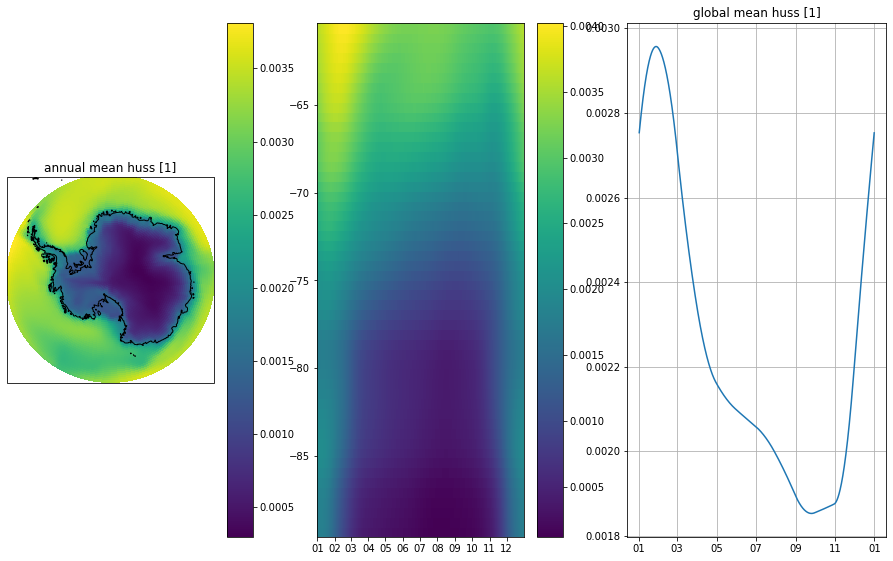

In [95]:
    import numpy as np
    import xarray as xr
    import matplotlib.pyplot as plt
    from matplotlib.dates import DateFormatter
    import cartopy
    import cartopy.crs as ccrs
    fig=plt.figure(figsize=(np.array([400,120*2]) / 25.4))
    grid = plt.GridSpec(1, 3, wspace=0.2, hspace=0.3)


    # plot
    ivar=0
    cvar='dhuss'
    print(cvar)
    #ax = fig.add_subplot(grid[ivar,0:2], projection=ccrs.Robinson(central_longitude=0))
    ax = fig.add_subplot(grid[ivar,0], projection=ccrs.Stereographic(central_latitude=-90.0, central_longitude=0.0))
    pcol=ax.pcolormesh(ds_annual['lon'],ds_annual['lat'],ds_annual[cvar],transform=ccrs.PlateCarree())
    ax.contour(ds_annual['lon'],ds_annual['lat'],ds_annual[cvar],levels=[-999999,0,999999],colors='w',transform=ccrs.PlateCarree())
    ax.coastlines()
    XY_lim=[(-180, 180, -90, -60),ccrs.PlateCarree()]
    ax.set_extent(XY_lim[0], XY_lim[1])
    ax.set_title('annual mean '+fvar+' ['+ds_month[cvar].attrs['units']+']')
    plt.colorbar(pcol)

    toto=ds_month.mean(dim='lon')
    ax = fig.add_subplot(grid[ivar,1])
    pcol=ax.pcolormesh(toto['time'],toto['lat'],toto[cvar].transpose())
    ax.contour(toto['time'],toto['lat'],toto[cvar].transpose(),levels=[-99999,0,9999999],colors='w')
    date_form = DateFormatter("%m")
    ax.xaxis.set_major_formatter(date_form)
    plt.colorbar(pcol)

    ax = fig.add_subplot(grid[ivar,2])
    ax.plot(ds_ts['time'],ds_ts[cvar])
    ax.grid()
    ax.set_title('global mean '+fvar+' ['+ds_month[cvar].attrs['units']+']')
    date_form = DateFormatter("%m")
    ax.xaxis.set_major_formatter(date_form)

In [96]:
# define figure
fig=plt.figure(figsize=(np.array([400,120*6]) / 25.4))
grid = plt.GridSpec(len(fvarlst), 3, wspace=0.2, hspace=0.3)

# process all data
for ivar, fvar in enumerate(['huss']):
    cvar='d'+cvarlst[ivar]
    
    # load data
    print('    load anomaly data ...')
    cfile='IPSL-CM6A-LR_ssp585-historical_{}_3h_ano_{}_on_JRA_grid.nc'.format(fvar,cfext)
    print('        file : {}'.format(cfile))
    ds_month = xr.open_dataset(cfile).sel(lat=slice(-90,-60))
    
    # compute anual mean
    ds_annual=ds_month.mean(dim='time')
    
    # compute global mean time series
    # compute weights
    weights = np.cos(np.deg2rad(ds_month.lat,dtype=np.float64))
    
    # compute weighted xarray
    weights.name = "weights"
    dsw = ds_month.weighted(weights)
    
    # display anomaly
    ds_ts=dsw.mean(("lon", "lat"))

    # plot
    vmin=np.min(ds_annual[cvar].values)
    vmax=np.max(ds_annual[cvar].values)
    print(vmax,vmin)
    print(ds_annual[cvar].values)

    load anomaly data ...
        file : IPSL-CM6A-LR_ssp585-historical_huss_3h_ano_22602299-19752014_on_JRA_grid.nc
0.003808689978933411 0.0002991283431387952
[[0.00058857 0.00058825 0.00058791 ... 0.00058945 0.00058917 0.00058887]
 [0.00062411 0.00062331 0.00062244 ... 0.00062585 0.00062533 0.00062476]
 [0.00064167 0.00064041 0.00063899 ... 0.00064403 0.00064336 0.0006426 ]
 ...
 [0.00353722 0.0035333  0.00352947 ... 0.00354775 0.0035447  0.00354109]
 [0.0035439  0.00354193 0.00353999 ... 0.00354867 0.00354748 0.00354581]
 [0.0035452  0.00354524 0.00354529 ... 0.0035445  0.00354493 0.00354513]]


<Figure size 1133.86x2040.94 with 0 Axes>